In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import wfdb

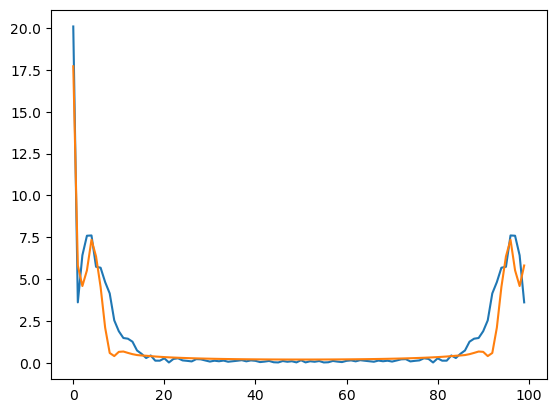

In [2]:
sig = wfdb.rdsamp("mit-bih-data/100")
x_2_sigs = sig[0][:2000].flatten()
x = x_2_sigs[::2]
x2 = x_2_sigs[1::2]
fs = wfdb.rdsamp("mit-bih-data/100")[:20000][1]['fs']
frek = np.fft.fft(x, n=100)
plt.plot(np.abs(frek))

filter = signal.butter(4, 20, 'low', fs=fs, output='sos')
y = signal.sosfilt(filter, x)
plt.plot(np.abs(np.fft.fft(y, n=100)))  


In [3]:
# Specify the record name (without extension) and annotation extension
record_name = 'mit-bih-data/105'  # Example record (e.g., '100' for '100.dat' and '100.atr')
annotation = wfdb.rdann(record_name, 'atr')
samples = annotation.sample[:8]
print(samples)


[  67  197  459  708  965 1222 1479 1741]


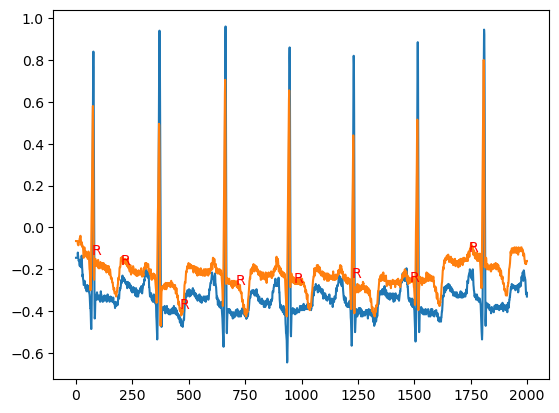

In [4]:
plt.plot(x)
for sampe in samples:
    plt.text(sampe, x2[sampe], 'R', color='red')
plt.plot(x2)
plt.show()

In [5]:
#write data into asc file
data = np.array(range(70, 3000, 300))
np.savetxt('dataout/data.asc', data, fmt='%d')


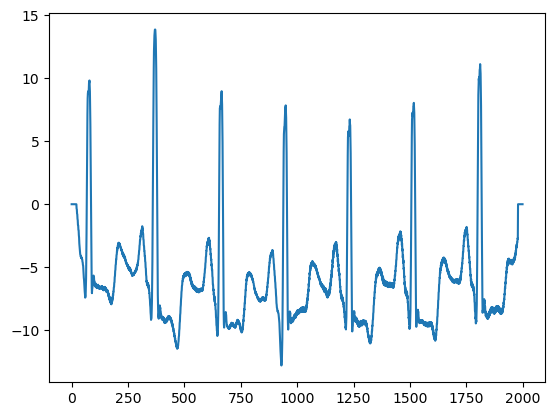

In [6]:
#haar filter
B1 = int(0.025*fs)
B2 = int(0.06*fs)
c = 2 * (B2 - B1)/(2*B1 +1)

# technically don't need this
h_haar = np.zeros(2*B1 + 2*B2 )
h_haar[0:B2] = -1
h_haar[B2:2*B1 + B2] = c
h_haar[2*B1 + B2:2*B1+2*B2] = -1


#implementation, 
y1 = np.zeros(len(x))
y2= np.zeros(len(x))
y = np.zeros(len(x))
for i in range(len(y2)):
    if i < B2 or i >= len(x2)-B2:
        continue      
    else:
        y1[i] = (c+1)*(x[i+B1] - x[i-B1]) + y1[i-1]
        y2[i] = -(x[i+B2] - x[i-B2] + y2[i-1])
        y[i] = y1[i] + y2[i]

        
y = y1 + y2
plt.plot(y)

In [7]:
#popravki - lahko rajš paddaš kot skippaš

def haar_filter(x,fs):
    #constants
    B1 = int(0.025*fs)
    B2 = int(0.06*fs)
    c = 2 * (B2 - B1)/(2*B1 +1)
    #signals
    y1 = np.zeros(len(x))
    y2= np.zeros(len(x))
    y = np.zeros(len(x))
    #go through samples
    for i in range(len(x)):
        #skip a few samples
        if i < B2 or i >= len(x)-B2:
            continue  
        #filter each sample   
        else:
            y1[i] = (c+1)*(x[i+B1] - x[i-B1]) + y1[i-1]
            y2[i] = -(x[i+B2] - x[i-B2] + y2[i-1])
            y[i] = y1[i] + y2[i]

    return y

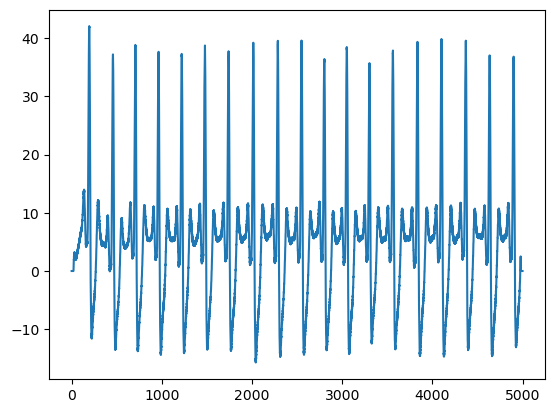

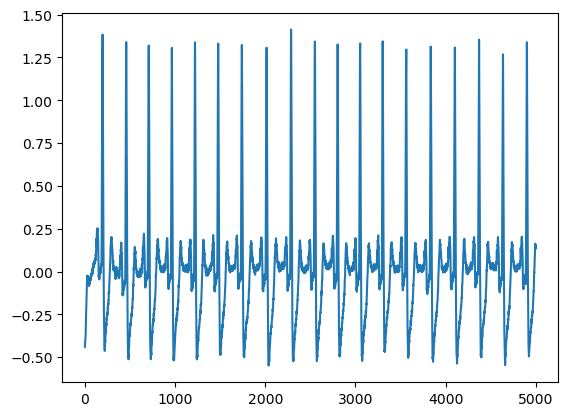

In [8]:
#read signal
sig = wfdb.rdsamp("mit-bih-data/105")
x_both = sig[0][:5000].flatten()
x = x_both[::2]
#read sampling frequency
fs = wfdb.rdsamp("mit-bih-data/105")[1]['fs']
#read annotation file
record_name = 'mit-bih-data/105' 
annotation = wfdb.rdann(record_name, 'atr')
#get rid of baseline
butter_filter = signal.butter(3, 0.6, 'high', fs=fs, output='sos')
x_no_baseline = signal.sosfilt(butter_filter, x)
#apply haar filter
y = haar_filter(x_no_baseline,fs)
plt.plot(y)
plt.figure()
plt.plot(x_no_baseline)

In [9]:
#popravki 

def get_candidates(y,x_no_baseline, fs, c1 = 0.55):
    x2 = np.zeros(len(x))
    #fill x2 by the formula from paper
    x2[1:len(x)-1] = np.array( [2 * x_no_baseline[n] - x_no_baseline[n+1] - x_no_baseline[n-1] for n in range(1, len(x)-1)] )
    #calculate s
    s = np.array([y[n]*(x_no_baseline[n] + c1*x2[n]) for n in range(len(y))])
    #tmp just to find the correct range of checking
    tmp = int(0.2*fs)
    #find candidates
    candidates =[]
    for k in range(tmp, len(s)-tmp):
        for n in range(-tmp, tmp):
            if np.abs(s[k]) < np.abs(s[k+n]):
                break
            elif n == tmp-1:
                candidates.append(k)

    return candidates, s
    

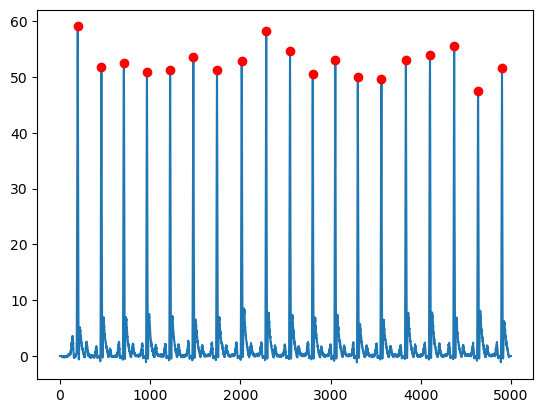

In [10]:
candidates,s = get_candidates(y,x_no_baseline,fs)
plt.plot(s)
plt.plot(candidates, [s[n] for n in candidates], 'ro')

In [ ]:
#še popravki - skippam če jih ni 5 še prepoznanih (za W1 in W2) - da se bolš nrdit


def detect_beats(s,candidates, fs, T=0.5, beta1=0.5, beta2=0.5, taus=[0.08,  0.12, 0.2, 0.25, 0.35], omega_treshold = 0.1):
    
    #current s in the window
    s_current = []
    #window size
    seconds_window = 10
    samples_window = fs*seconds_window

    #recent detected number
    recent_detected_num = 5

    #detected beats
    detected = []

    #for every candidate
    for i in candidates:
        s_current = []
        for j in range(i-samples_window, i):
            #skip if out of range
            if j < 0:
                continue
            s_current.append(s[j])

        #calculate W1
        W1 = T
        if len(s_current) > 5:
            W1 = sorted(s_current)[-5] +T
            

        #calculate W2
        W2 = beta1
        det_len = len(detected)
        #only if there is at least 5 detected beats
        if det_len > 5:
            recent_det = detected[det_len - recent_detected_num: det_len]

            mew = np.mean([recent_det[i] - recent_det[i+1] for i in range(3)])


            
            if recent_det[-2] - recent_det[-3] < 0.7*mew and det_len > 6:
                print('here')
                tmp = recent_det

                recent_det = [detected[-6]]
                recent_det.extend(tmp[:-1])

            recent_det.append(i)
                

            Ie = sum([taus[i] * (recent_det[i] - recent_det[i+1]) for i in range(5)])

            
            W2 = beta1 + beta2 * abs((i - recent_det[0])/Ie - round((i - recent_det[0])/Ie))
            
        treshold = W1*W2


        omega = 1/2
        if i - int(0.1*fs) > 0:
            tmp_list=  [x_no_baseline[j] for j in range(i - int(0.1*fs), i + int(0.1*fs))]
            u1 = max(tmp_list) - min(tmp_list)
            u2 = sum([abs(x_no_baseline[j] - x_no_baseline[j-1]) for j in range(i - int(0.1*fs), i + int(0.1*fs))])
            omega = u1/u2


        if s[i] > treshold and omega > omega_treshold:
                detected.append(i)

    return detected



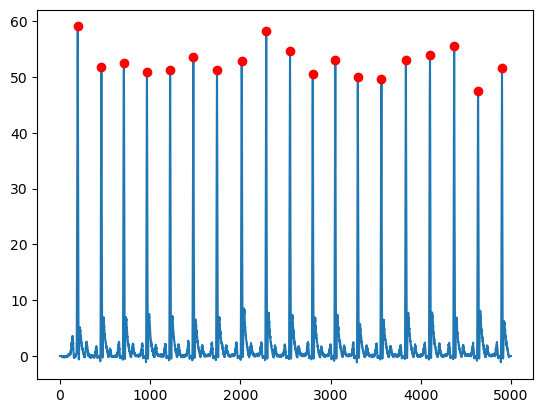

In [22]:
detected = detect_beats(s,candidates, fs)
plt.plot(s)
plt.plot(detected, [s[n] for n in detected], 'ro')
#plt.plot(candidates, [s[n] for n in candidates], 'bo')